# IMPORT DATASET

In [1]:
"""# Install kaggle dan kagglehub jika belum
!pip install -q kagglehub

import kagglehub

# Download dataset dari Kaggle (otomatis simpan ke cache)
path = kagglehub.dataset_download("aliefrahmanhakim/type-of-plastic-waste-dataset")
print("Path to dataset files:", path)"""

'# Install kaggle dan kagglehub jika belum\n!pip install -q kagglehub\n\nimport kagglehub\n\n# Download dataset dari Kaggle (otomatis simpan ke cache)\npath = kagglehub.dataset_download("aliefrahmanhakim/type-of-plastic-waste-dataset")\nprint("Path to dataset files:", path)'

In [2]:
import os
import numpy as np
import random
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import shutil
from PIL import Image

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from sklearn.model_selection import train_test_split
from tensorflow.keras import Input
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import (GlobalAveragePooling2D, Conv2D, MaxPool2D, Flatten, Dense,
                                     Dropout, Input, BatchNormalization)
from tensorflow.keras.callbacks import CSVLogger, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, Callback
from tensorflow.keras.applications import EfficientNetB7
from tensorflow.keras.applications.efficientnet import preprocess_input
from sklearn.utils.class_weight import compute_class_weight

from sklearn.metrics import confusion_matrix, classification_report

# Mengabaikan peringatan
import warnings
warnings.simplefilter('ignore')

2025-06-12 16:04:35.417007: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749744275.612261      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749744275.670183      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# DATA LOAD

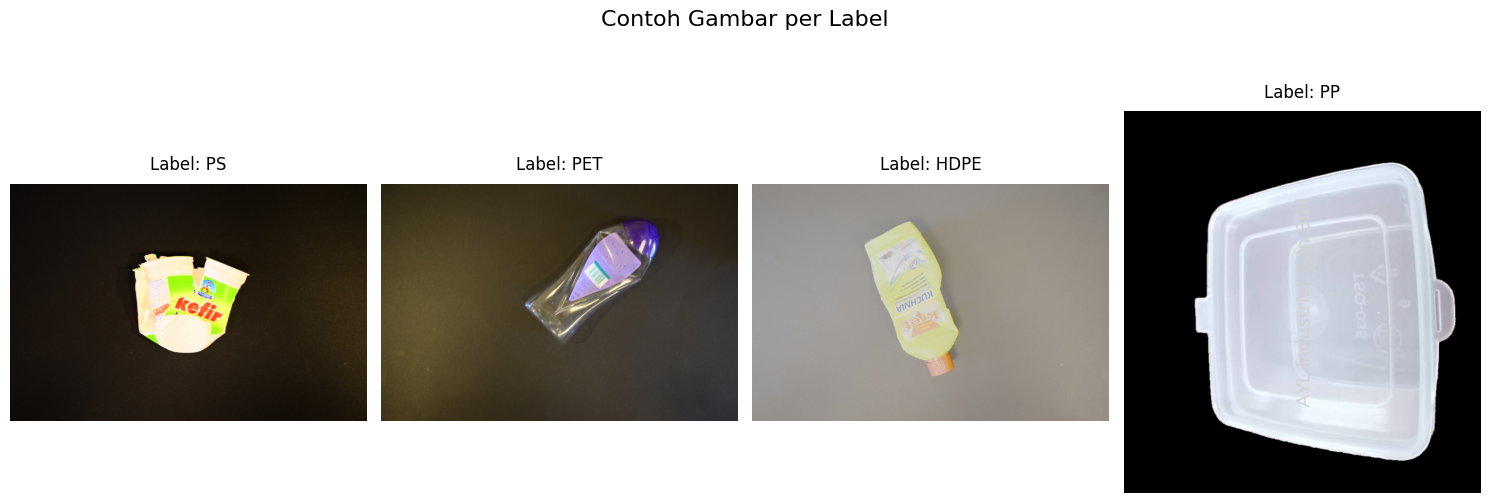

In [3]:
# Path dataset
df = "/kaggle/input/type-of-plastic-waste-dataset"

# mengelompokkan berdasarkan label
label_to_images = {}  # Kamus: {label: [list_path_gambar]}

for root, dirs, files in os.walk(df):
    for file in files:
        if file.lower().endswith(('.png', '.jpg', '.jpeg')):
            label = os.path.basename(root)  
            if label not in label_to_images:
                label_to_images[label] = []
            label_to_images[label].append(os.path.join(root, file))

# Menampilkan 1 gambar acak per label 
labels = list(label_to_images.keys())
if len(labels) > 4:
    labels = random.sample(labels, 4)  # Ambil 4 label acak jika label > 4

selected_images = []
for label in labels:
    images = label_to_images[label]
    selected_images.append((label, random.choice(images)))  # (label, path_gambar)

plt.figure(figsize=(15, 5))
plt.suptitle("Contoh Gambar per Label", fontsize=16, y=1.05)  # Judul utama

for i, (label, img_path) in enumerate(selected_images):
    img = Image.open(img_path)
    
    plt.subplot(1, 4, i + 1)
    plt.imshow(img)
    plt.title(f"Label: {label}", pad=10)  # `pad` memberi jarak antara judul dan gambar
    plt.axis('off')

plt.tight_layout()
plt.show()

# DATA UNDERSTANDING

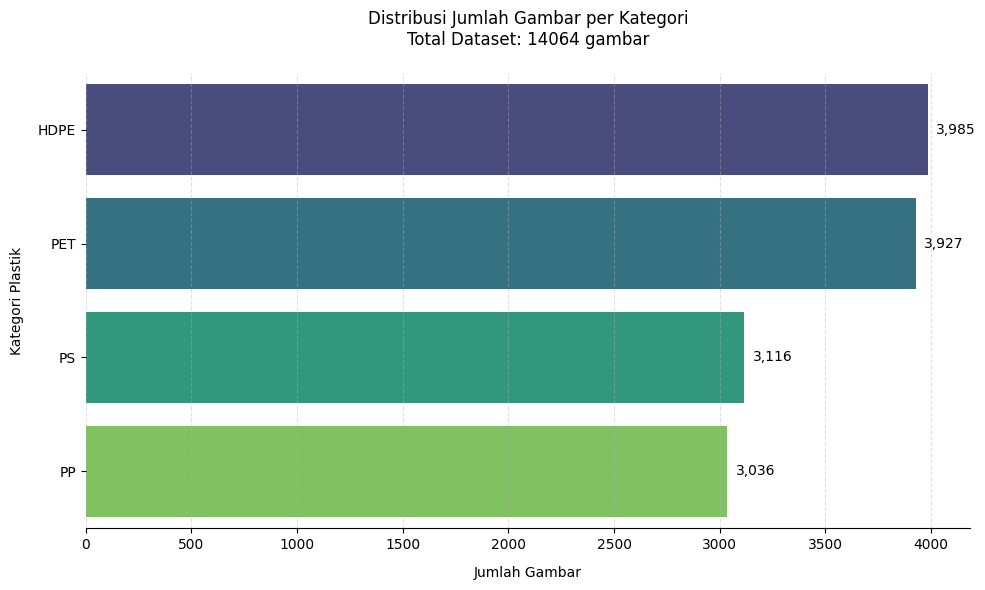

In [4]:
# Menghitung jumlah gambar per kategori
category_counts = {}
total_images = 0  
image_paths = []

for root, dirs, files in os.walk(df):
    for file in files:
        if file.lower().endswith(('.jpg', '.png', '.jpeg')):
            label = os.path.basename(root)  
            category_counts[label] = category_counts.get(label, 0) + 1
            total_images += 1
            image_paths.append(os.path.join(root, file))

# Konversi ke DataFrame
df_counts = pd.DataFrame(list(category_counts.items()), columns=["Label", "Jumlah Gambar"])
df_counts = df_counts.sort_values("Jumlah Gambar", ascending=False)  

# Visualisasi bar chart
plt.figure(figsize=(10, 6))
barplot = sns.barplot(
    data=df_counts,
    y="Label",  
    x="Jumlah Gambar",  
    palette="viridis",  
    orient="h"  
)

# Tambahkan nilai di ujung bar
for i, value in enumerate(df_counts["Jumlah Gambar"]):
    barplot.text(
        value + max(df_counts["Jumlah Gambar"])*0.01,  
        i,  # Posisi Y
        f"{value:,}", 
        ha='left',  
        va='center',  
        fontsize=10
    )

plt.title(f"Distribusi Jumlah Gambar per Kategori\nTotal Dataset: {total_images} gambar", pad=20)
plt.xlabel("Jumlah Gambar", labelpad=10)
plt.ylabel("Kategori Plastik", labelpad=10)
plt.grid(axis='x', linestyle='--', alpha=0.4)  
sns.despine(left=True)  
plt.tight_layout()
plt.show()

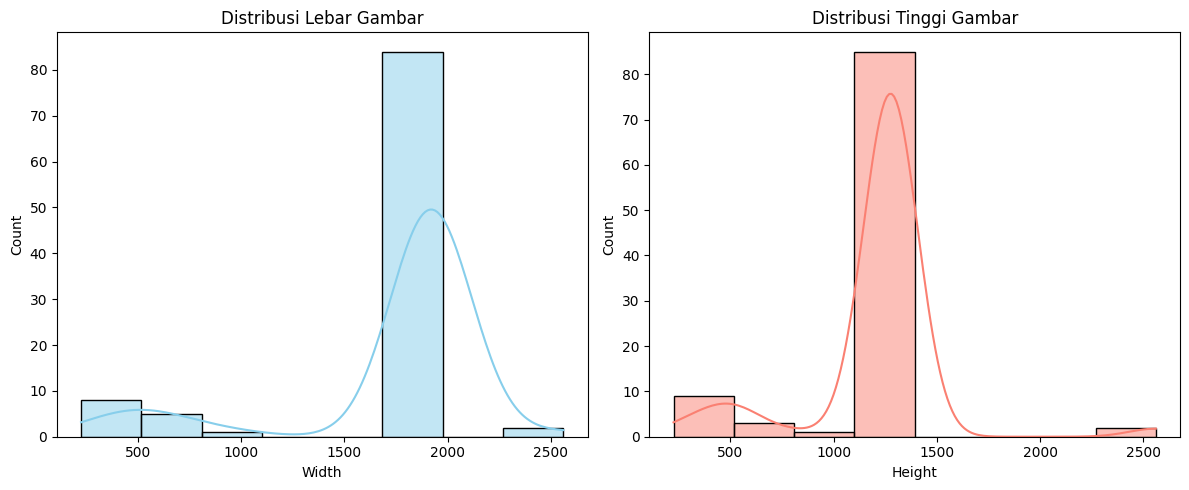

In [5]:
# Menampilkan distribusi ukuran gambar
image_sizes = []
sample_images = random.sample(image_paths, min(100, len(image_paths)))  # contoh 100 gambar

for img_path in sample_images:
    try:
        with Image.open(img_path) as img:
            image_sizes.append(img.size)  # (width, height)
    except:
        continue

# Konversi ke DataFrame
df_sizes = pd.DataFrame(image_sizes, columns=['Width', 'Height'])

# Visualisasi distribusi ukuran
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.histplot(df_sizes['Width'], kde=True, color='skyblue')
plt.title("Distribusi Lebar Gambar")

plt.subplot(1, 2, 2)
sns.histplot(df_sizes['Height'], kde=True, color='salmon')
plt.title("Distribusi Tinggi Gambar")

plt.tight_layout()
plt.show()

# DATA SPLITTING

In [6]:
# Direktori training dan testing (80/20)
TRAIN_DIR = "/kaggle/input/type-of-plastic-waste-dataset/train"
TEST_DIR = "/kaggle/input/type-of-plastic-waste-dataset/val"

train_HDPE = os.path.join(TRAIN_DIR + '/HDPE')
train_PET = os.path.join(TRAIN_DIR + '/PET')
train_PP = os.path.join(TRAIN_DIR + '/PP')
train_PS = os.path.join(TRAIN_DIR + '/PS')
test_HDPE = os.path.join(TEST_DIR + '/HDPE')
test_PET = os.path.join(TEST_DIR + '/PET')
test_PP = os.path.join(TEST_DIR + '/PP')
test_PS = os.path.join(TEST_DIR + '/PS')

print("TRAIN\n")
print("Total number of HDPE images in training set: ",len(os.listdir(train_HDPE)))
print("Total number of PET images in training set: ",len(os.listdir(train_PET)))
print("Total number of PP images in training set: ",len(os.listdir(train_PP)))
print("Total number of PS images in training set: ",len(os.listdir(train_PS)))
print("\nTEST\n")
print("Total number of HDPE images in test set: ",len(os.listdir(test_HDPE)))
print("Total number of PET images in test set: ",len(os.listdir(test_PET)))
print("Total number of PP images in test set: ",len(os.listdir(test_PP)))
print("Total number of PS images in test set: ",len(os.listdir(test_PS)))

TRAIN

Total number of HDPE images in training set:  3188
Total number of PET images in training set:  3142
Total number of PP images in training set:  2429
Total number of PS images in training set:  2493

TEST

Total number of HDPE images in test set:  797
Total number of PET images in test set:  785
Total number of PP images in test set:  607
Total number of PS images in test set:  623


In [7]:
# Mempersiapkan data gambar untuk pelatihan
datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,  
    validation_split=0.2
)
test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input   
)

train_generator = datagen.flow_from_directory(TRAIN_DIR,
                                              batch_size=32,
                                              target_size=(512,512),
                                              class_mode='categorical',
                                              subset='training',
                                              shuffle=True)

validation_generator = datagen.flow_from_directory(TRAIN_DIR,
                                                   batch_size=32,
                                                   target_size=(512,512),
                                                   class_mode='categorical',
                                                   subset='validation',
                                                   shuffle=False)

test_generator = test_datagen.flow_from_directory(TEST_DIR,
                                                  batch_size=1,
                                                  target_size=(512,512),
                                                  class_mode='categorical',
                                                  shuffle=False)

Found 9004 images belonging to 4 classes.
Found 2248 images belonging to 4 classes.
Found 2812 images belonging to 4 classes.


# MODELLING

## EfficientNet

In [8]:
# Load model EfficientNetB7
base_model = EfficientNetB7(
    weights='imagenet', 
    include_top=False, 
    input_shape=(512,512,3)  
)

# Menambahkan top model 
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dense(512, activation='relu')(x)  
x = Dropout(0.5)(x)  # Dropout 
x = Dense(256, activation='relu')(x)  # Layer tambahan
x = Dropout(0.3)(x) 
predictions = Dense(4, activation='softmax')(x) 

model_3 = Model(inputs=base_model.input, outputs=predictions)

I0000 00:00:1749744310.073582      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


258076736/258076736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [9]:
RESULT_PATH = ''  # Ganti dengan path hasil pelatihan
OUTPUT_DIR = '/kaggle/working/outputs'

if os.path.exists(f"{RESULT_PATH}/training_outputs"):
    print("Memuat file hasil training sebelumnya...")
    os.makedirs(OUTPUT_DIR, exist_ok=True)
    
    # Copy dari dataset ke working directory
    shutil.copytree(f"{RESULT_PATH}/training_outputs", OUTPUT_DIR, dirs_exist_ok=True)
    
    # Pindahkan file ke root working directory
    for file in ['final_model_3.h5', 'best_model_3.h5', 'training_history_3.csv', 'training_log_3.csv']:
        if os.path.exists(f"{OUTPUT_DIR}/{file}"):
            shutil.copy(f"{OUTPUT_DIR}/{file}", '/kaggle/working/')


model_path = 'final_model_3.h5'
best_model_path = 'best_model_3.h5'
history_path = 'training_history_3.csv'
log_path = 'training_log_3.csv'
retrain = False # Ganti menjadi true jika ingin training ulang

if os.path.exists(model_path) and not retrain:
    print("Model sudah dilatih sebelumnya. Memuat hasil yang tersimpan...")
    
    # Muat model
    model_3 = load_model(model_path)
    
    # Muat history dan tampilkan
    history_df = pd.read_csv(history_path)
    print("\n=== Riwayat Pelatihan ===")
    print(history_df.tail())  
    
    # Tampilkan log epoch dari CSVLogger 
    if os.path.exists(log_path):
        epoch_logs = pd.read_csv(log_path)
        print("\n=== Log Epoch Lengkap ===")
        print(epoch_logs)

else:
    print("Model belum dilatih. Memulai pelatihan...")
    
    # Hapus file lama jika ada
    for f in [model_path, history_path, log_path, best_model_path]:
        if os.path.exists(f):
            os.remove(f)
    
    # Simpan log training ke CSV
    csv_logger = CSVLogger(log_path)
    
    # Simpan model terbaik selama training
    checkpoint = ModelCheckpoint(
        best_model_path,
        monitor='val_loss',
        save_best_only=True,
        mode='min',
        verbose=1
    )
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=15,  
        min_delta=0.0001,
        restore_best_weights=True,
        verbose=1
    )
    
    reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    min_lr=1e-7,
    mode='min',
    verbose=1
    )
    
    class_indices = train_generator.classes
    class_weights = compute_class_weight('balanced', 
                                        classes=np.unique(class_indices), 
                                        y=class_indices)
    class_weights_dict = dict(enumerate(class_weights))
        
    base_model.trainable = False

    # Melatih Head model
    initial_lr = 1e-3 
    model_3.compile(
        optimizer=Adam(learning_rate=initial_lr),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    # Melatih head epoch
    epochs_head = 15
    history_head = model_3.fit(
        train_generator,
        epochs=epochs_head, # Latih head selama 10 epoch dulu
        validation_data=validation_generator,
        class_weight=class_weights_dict,
        callbacks=[csv_logger, checkpoint, early_stopping, reduce_lr] # Tanpa unfreeze callback
    )

    # Unfreeze (fine-tuning)
    base_model.trainable = True
    
    freeze_first_n = 400
    for layer in base_model.layers[:freeze_first_n]:
        layer.trainable = False
    
    finetune_lr = 1e-5
    model_3.compile(
        optimizer=Adam(learning_rate=finetune_lr), # LR rendah!
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    # Melanjutkan pelatihan untuk sisa epoch
    total_epochs = 100
    initial_epoch_finetune = history_head.epoch[-1] + 1
    
    history_finetune = model_3.fit(
        train_generator,
        epochs=total_epochs, 
        initial_epoch=initial_epoch_finetune, 
        validation_data=validation_generator,
        class_weight=class_weights_dict,
        callbacks=[csv_logger, checkpoint, early_stopping, reduce_lr] 
    )
    print(f"Memuat bobot terbaik dari {best_model_path} sebelum menyimpan model final.")
    model_3.load_weights(best_model_path)
    
    # Simpan model akhir
    model_3.save(model_path)
    
    # Simpan history ke DataFrame
    history_head_df = pd.DataFrame(history_head.history)
    history_finetune_df = pd.DataFrame(history_finetune.history)
    full_history_df = pd.concat([history_head_df, history_finetune_df], ignore_index=True)
    full_history_df.to_csv(history_path, index=False)

    print(f"Model akhir disimpan di: {model_path}")
    print(f"History lengkap disimpan di: {history_path}")
    
    os.makedirs(OUTPUT_DIR, exist_ok=True)
    
    for file in [model_path, best_model_path, history_path, log_path]:
        if os.path.exists(file):
            shutil.copy(file, OUTPUT_DIR)
    
    shutil.make_archive('training_outputs', 'zip', OUTPUT_DIR)
    print("File hasil training siap di-download!")

Model belum dilatih. Memulai pelatihan...
Epoch 1/15


I0000 00:00:1749744371.655964      83 service.cc:148] XLA service 0x7847280043c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1749744371.656900      83 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1749744378.099611      83 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1749744414.173342      83 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


282/282 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8606 - loss: 0.4973
Epoch 1: val_loss improved from inf to 0.22923, saving model to best_model_3.h5
282/282 ━━━━━━━━━━━━━━━━━━━━ 545s 2s/step - accuracy: 0.8607 - loss: 0.4967 - val_accuracy: 0.9364 - val_loss: 0.2292 - learning_rate: 0.0010
Epoch 2/15
282/282 ━━━━━━━━━━━━━━━━━━━━ 0s 684ms/step - accuracy: 0.9625 - loss: 0.1537
Epoch 2: val_loss did not improve from 0.22923
282/282 ━━━━━━━━━━━━━━━━━━━━ 247s 873ms/step - accuracy: 0.9625 - loss: 0.1537 - val_accuracy: 0.9288 - val_loss: 0.2741 - learning_rate: 0.0010
Epoch 3/15
282/282 ━━━━━━━━━━━━━━━━━━━━ 0s 680ms/step - accuracy: 0.9702 - loss: 0.1018
Epoch 3: val_loss improved from 0.22923 to 0.16481, saving model to best_model_3.h5
282/282 ━━━━━━━━━━━━━━━━━━━━ 248s 878ms/step - accuracy: 0.9702 - loss: 0.1018 - val_accuracy: 0.9528 - val_loss: 0.1648 - learning_rate: 0.0010
Epoch 4/15
282/282 ━━━━━━━━━━━━━━━━━━━━ 0s 676ms/step - accuracy: 0.9764 - loss: 0.0838
Epoch 4: val_loss d

E0000 00:00:1749748444.100428      84 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1749748444.363496      84 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1749748445.708746      84 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1749748446.017106      84 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1749748447.077022      84 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:0

 17/282 ━━━━━━━━━━━━━━━━━━━━ 6:57 2s/step - accuracy: 0.6879 - loss: 1.1771

E0000 00:00:1749748539.431715      82 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1749748539.679851      82 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1749748540.503592      82 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1749748540.792169      82 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1749748541.579477      82 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:0

282/282 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8525 - loss: 0.4900
Epoch 16: val_loss did not improve from 0.16481
282/282 ━━━━━━━━━━━━━━━━━━━━ 778s 2s/step - accuracy: 0.8527 - loss: 0.4892 - val_accuracy: 0.9395 - val_loss: 0.2258 - learning_rate: 1.0000e-05
Epoch 17/100
282/282 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9662 - loss: 0.1197
Epoch 17: val_loss did not improve from 0.16481
282/282 ━━━━━━━━━━━━━━━━━━━━ 499s 2s/step - accuracy: 0.9662 - loss: 0.1196 - val_accuracy: 0.9480 - val_loss: 0.2027 - learning_rate: 1.0000e-05
Epoch 18/100
282/282 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9818 - loss: 0.0484
Epoch 18: val_loss did not improve from 0.16481
282/282 ━━━━━━━━━━━━━━━━━━━━ 500s 2s/step - accuracy: 0.9818 - loss: 0.0483 - val_accuracy: 0.9453 - val_loss: 0.2008 - learning_rate: 1.0000e-05
Epoch 19/100
282/282 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9874 - loss: 0.0345
Epoch 19: val_loss did not improve from 0.16481
282/282 ━━━━━━━━━━━━━━━━━━━━ 499s 2

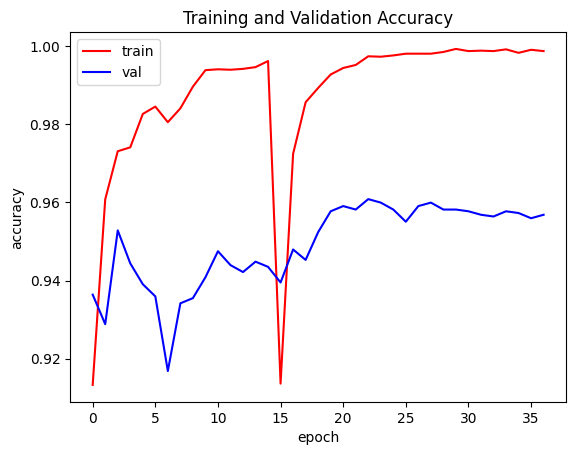

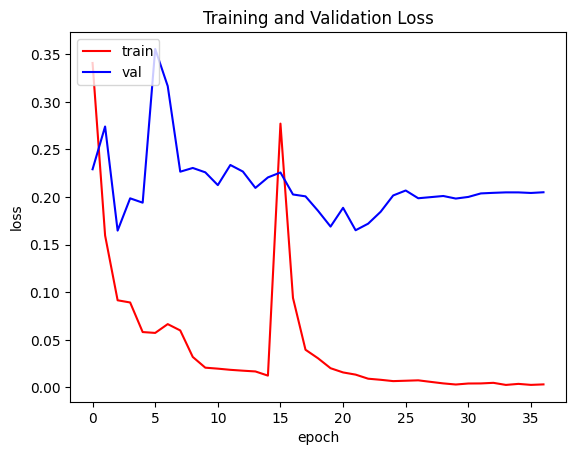

In [10]:
# Menampilkan grafik hasil akurasi dan loss 
acc = full_history_df['accuracy']
val_acc = full_history_df['val_accuracy']
loss = full_history_df['loss']
val_loss = full_history_df['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and Validation Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.title('Training and Validation Loss')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

2812/2812 ━━━━━━━━━━━━━━━━━━━━ 135s 41ms/step


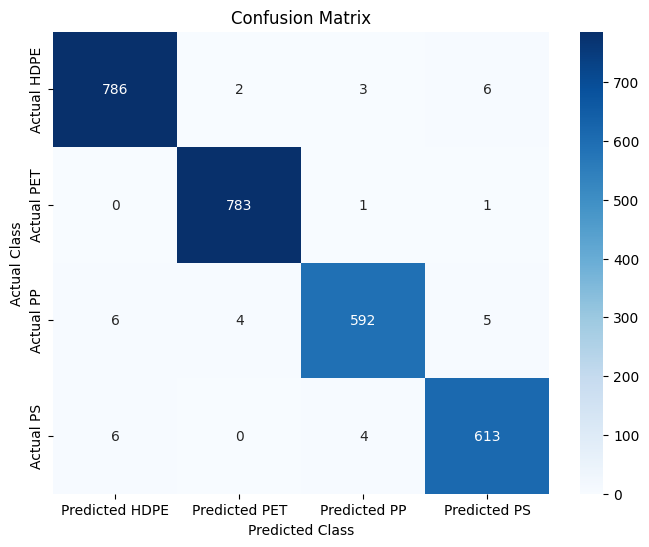


Classification Report:
              precision    recall  f1-score   support

        HDPE     0.9850    0.9862    0.9856       797
         PET     0.9924    0.9975    0.9949       785
          PP     0.9867    0.9753    0.9809       607
          PS     0.9808    0.9839    0.9824       623

    accuracy                         0.9865      2812
   macro avg     0.9862    0.9857    0.9860      2812
weighted avg     0.9865    0.9865    0.9865      2812



In [11]:
# Menampilkan confusion matrix
test_generator.reset()

preds_3 = model_3.predict(test_generator, steps=len(test_generator), verbose=1)
pred_labels = np.argmax(preds_3, axis=1)  

# Ground truth
true_labels = test_generator.classes
class_names = list(test_generator.class_indices.keys())  

# Confusion Matrix
cm = confusion_matrix(true_labels, pred_labels)
cm_df = pd.DataFrame(cm, index=[f'Actual {c}' for c in class_names],
                        columns=[f'Predicted {c}' for c in class_names])

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.ylabel("Actual Class")
plt.xlabel("Predicted Class")
plt.show()

# Classification Report
print("\nClassification Report:")
print(classification_report(true_labels, pred_labels, target_names=class_names, digits=4))